<a href="https://colab.research.google.com/github/darioblandon/Curso2/blob/master/S5/S5_C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<h1> Diplomado de Análisis de datos y Machine Learning en Python</h1>


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

Empecemos por usar la versión 2 de de tensor flow:

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Batch Normalization

Hemos visto que es una buena práctica normalizar los datos de entrada. Este procedimiento también ayuda en las capas intermedias para reducir el problema de los gradientes que se desvanecen. En estas capas se conoce como Batch Normalization y se busca reescalar los datos de manera que cambie su media y desviación estándar.

Un perceptrón multicapa sigue la siguiente estructura:

$$X^l=f^l(X^{l-1}A^l+B^l)$$

De aquí vemos que hay 3 formas de atacar al problema de los gradientes que se desvancen.


*   Funciones de Activación $f^l$ que no se saturan (ReLU,SELU)
*   Inicialización de $A^l$ y $B^l$ (Glorot, He)
*   Normalización de $X^l$ (Batch Normalization)

En sesiones anteriores se discutieron las 2 primeras alternativas y en este caso se analizará el Batch Normalization.

El primer paso consta en normalizar los datos:

$$X^l\to \frac{X^l-\mu^l}{\sigma^l}$$

Dónde $\mu^l$ y $\sigma^l$ son el promedio y la desviación estándar por lote de datos en la capa $l$. De esta manera, los datos en la capa $l$ quedaran normalizados con media nula y desviación estándar unitaria. Durante el entrenamiento deben acumularse los valores de $\mu^l$ y $\sigma^l$ de todos los lotes de datos para usarlos a la hora de realizar inferencia.  De aquí salen 2 parámetros por cada nodo (promedio y desviación) que se deben tener en cuenta. Sin embargo, estos parámetros no se optimizan usando gradiente descendente sino que se calculan por lotes.

No es suficiente estandarizar los datos con media nula y varianza unitaria. Es posible que la red neuronal aprenda una normalización más eficiente. Es por esto que los datos se reescalan nuevamente de la siguiente manera:

$$X^l\to \gamma \frac{X^l-\mu^l}{\sigma^l}+\beta$$

Dónde $\beta$ y $\gamma$ serán el nuevo promedio y desviación estándar de los datos. Estos parámetros si debe aprenderlos la red neuronal durante el entrenamiento, por lo que tenemos 2 parámetros entrenables adicionales por cada nodo.

Implementemos el Batch Normalization en Keras para el caso del dataset de Iris

In [ ]:
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization #Importar BatchNorm
from tensorflow.keras.utils import to_categorical

Se importan los datos, se normalizan y se hace un one-hot encoding de los labels

In [ ]:
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)

Se construye una red neuronal con 4 capas y Batch Normalization después de la segunda capa

In [ ]:
modelo=Sequential()
modelo.add(Dense(4,activation='relu',input_shape=(4,)))
modelo.add(Dense(4,activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Dense(4,activation='relu'))
modelo.add(Dense(3,activation='softmax'))
modelo.compile('sgd',loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 83
Non-trainable params: 8
_________________________________________________________________


En la capa de Batch Normalization hay 16 parámetros pero sólo 8 de esos son entrenables. Los 8 parámetros entrenables son los cuatro $\gamma$ y cuatro $\beta$ por cada neurona. Los 8 parámetros **no**-entrenables son los promedios $\mu^l$ y las desviaciones estándar $\sigma^l$ por cada nodo. Por último se entrena el modelo:

In [ ]:
modelo.fit(x=X,y=y, batch_size=10,epochs=500)

Train on 150 samples
Epoch 1/500
150/150 [==============================] - 1s 4ms/sample - loss: 1.1102 - acc: 0.4133
Epoch 2/500
150/150 [==============================] - 0s 192us/sample - loss: 1.0841 - acc: 0.5200
Epoch 3/500
150/150 [==============================] - 0s 137us/sample - loss: 0.9979 - acc: 0.5067
Epoch 4/500
150/150 [==============================] - 0s 132us/sample - loss: 1.0226 - acc: 0.4933
Epoch 5/500
150/150 [==============================] - 0s 145us/sample - loss: 0.9537 - acc: 0.5200
Epoch 6/500
150/150 [==============================] - 0s 134us/sample - loss: 0.8697 - acc: 0.5600
Epoch 7/500
150/150 [==============================] - 0s 173us/sample - loss: 0.9020 - acc: 0.5533
Epoch 8/500
150/150 [==============================] - 0s 141us/sample - loss: 0.9009 - acc: 0.5067
Epoch 9/500
150/150 [==============================] - 0s 140us/sample - loss: 0.8483 - acc: 0.5267
Epoch 10/500
150/150 [==============================] - 0s 136us/sample - loss: 0

# Gradient Clipping

Aparte de los gradientes que se desvanecen, es posible que al hacer Backpropagation, los gradientes se acumulen de tal manera que resulten valores computacionalmente grandes. Este problema se conoce como Gradientes que Explotan y para lidiar con él debe limitarse el valor del gradiente. Esta solución es mucho más sencilla que los gradientes que explotan y sólo implica darle estabilidad numérica al gradiente. En keras hay 2 formas de hacerlo:


*   Clip Norm: Se reescala todo el gradiente para que su norma no supere ciero umbral ($U$). Esta opción tiene la ventaja de conservar la dirección del gradiente:
$$\nabla J \to \nabla J \frac{U}{|\nabla J|}$$
*   Clip Value: Se reescalan únicamente los valores que superen cierto umbral ($U$).
$$(\nabla J)_i \to (\nabla J)_i \frac{U}{|\nabla J|_i}$$



El Gradient Clipping se implementa en el optimizador. Debido a esto debemos importar el optimizador explícitamente

In [ ]:
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD #Importar el optimizador
from tensorflow.keras.utils import to_categorical

Nuevamente se importan, se estandarizan y se codifican los datos

In [ ]:
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)

Se construye el modelo con 3 capas

In [ ]:
modelo=Sequential()
modelo.add(Dense(4,activation='sigmoid',input_shape=(4,)))
modelo.add(Dense(4,activation='sigmoid'))
modelo.add(Dense(4,activation='sigmoid'))
modelo.add(Dense(3,activation='softmax'))

El optimizador hace el gradient clipping con el argumento "clipnorm" o "clipvalue" dependiendo del modo que se elija:

In [ ]:
optim=SGD(clipnorm=1) #Se cortan los gradientes estableciendo un umbral máximo para la norma
modelo.compile(optim,loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 15        
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


Por último, se entrena la red:

In [ ]:
modelo.fit(x=X,y=y, batch_size=10,epochs=500)

# **Funciones de pérdida**:

Como hemos visto, las redes neuronales en DL son entrenadas usando el algoritmo de descenso del gradiente estocástico (o sus optimizaciones). 

La función de perdida hace parte del algoritmo de optimización, con el fin de estimar de forma repetida, el error del modelo al realizar una predicción. Lo anterior requiere escoger una función de error, comúnmente llamada pérdida, que puede ser usada para estimar la perdida del modelo de tal forma que los pesos puedan ser actualizados, para reducir dichas pérdidas en la siguiente evaluación.

Las redes neuronales aprende una función de mapeo de los datos de entrada a las clases o salidas; la escogencia de una función de pérdida debe concordar el modelo predictivo a resolver. Incluso, **como se ha visto**, la configuración de la capa de salida debe ser apropiada para la función de pérdida que se escoja. 

A continuación, estudiaremos las siguientes funciones de pérdida:

* Funciones de pérdida en el problema de regresión.
* Funciones de pérdida en la clasificación binaria.
* Funciones de pérdida en la clasificación multi-clases.

## **Funciones de pérdida en el problema de regresión**

Para el caso de un problema de regresión, tenemos las siguientes funciones de pérdidas (alguna de las cuales fueron estudiadas en el curso pasado, por lo que no se ahoradará más en ellas):

- Error cuadrático medio, cuyo error esta dado por la expresión

$$\text{MSE}(y,\hat{y}) = \frac{1}{n}\sum_{i=0}^n (y-\hat{y})^2$$

Esta función de pérdida es usada por defecto en los problemas de regresión. El cuadrado del error significa que los errores que son grandes tienen un mayor impacto que los pequeños, lo que significa que el modelo regula dichos errores grandes. 

- Error logarítmico cuadrático médio:

$$\text{MLSE}(y,\hat{y})=\frac{1}{N}\sum_{i=0}^N (log(y_i+1)-log(\hat{y}_i+1))^2$$

Esta función puede ser usada en los casos en los que la variable target tiene un rango amplio de valores y al calcular un error grande, es posible que no se desee penalizar el modelo tanto como lo hace MSE.

Para ello, primero se calcula el logaritmo natural de cada uno de los valores target (conocido y pronosticado), y luego se procede a calcular el error cuadrático medio. En conclusión, este error tienen el efecto de **relajar las penalizaciones sobre los errores grandes**.

- Error absoluto medio, cuyo error puede ser obtenido mediante la siguiente expresión:

$$\text{MAE}(y,\hat{y}) = \frac{1}{N}\sum_{i=0}^N|y_i-\hat{y}_i|$$

Este error puede ser usado en algunos problemas de regresión en los cuales, la distribución de la variable target, es gaussiana con valores atípicos/outliers (grandes o pequeños). En esto casos, la expresión anterior resulta robusta para dichos valores atípicos.


Usaremos un generador de problemas de regresión estándar mediante la librería de `scikit-learn`, mediante la función `make_regression()`. Esta función generará ejemplos a partir de un problema de regresión simple con un número dado de variables de entrada, ruido estadístico y otras propiedades.

Usaremos esta función para definir un problema con 20 características, 10 de las cuales serán relevantes y las otras 10 no. El generador de número pseudoaleatorios se fijará para obtener al menos 1000 ejemplos cada vez que ejecutemos el código.

In [ ]:
# Algunas librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

In [ ]:
 # generación de datos de regresión y preprocesado:

X, y = make_regression(n_samples=1000, n_features=20, random_state=1)

X_s = StandardScaler().fit_transform(X);
y_s = StandardScaler().fit_transform(y.reshape(-1,1));

n_train = 500
train_X, test_X = X_s[:n_train, :], X_s[n_train:, :]
train_y, test_y = y_s[:n_train], y_s[n_train:]

In [ ]:
def build_model(loss = 'mean_squared_error' ): 
  # define model
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
  model.add(keras.layers.Dense(1, activation='linear'))
  opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
  model.compile(loss=loss, optimizer=opt)
  return model

Train: 0.002, Test: 0.005


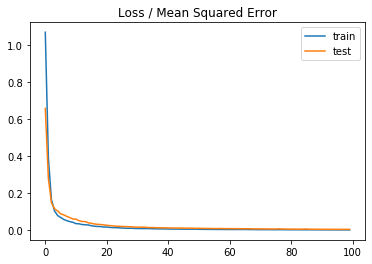

In [ ]:
# Función Mean Squared error

# define model
model = build_model()

# fit model
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train: 0.001, Test: 0.002


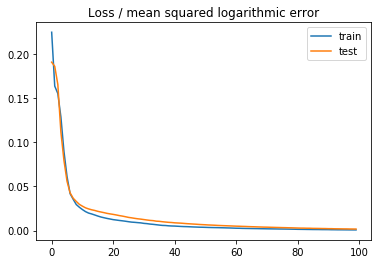

In [ ]:
# mean_squared_logarithmic_error

# define model
model = build_model(loss = 'mean_squared_logarithmic_error')

# fit model
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss / mean squared logarithmic error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train: 0.051, Test: 0.053


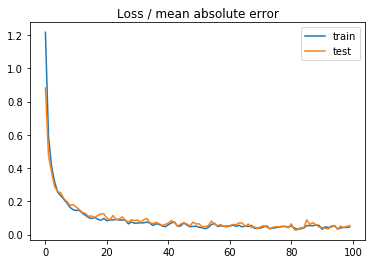

In [ ]:
# Mean Absolute Error Loss

# define model
model = build_model(loss = 'mean_absolute_error')

# fit model
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss / mean absolute error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **Funciones de pérdida en el problema de clasificación binaria**

Las funciones de pérdidas principales en los casos de clasificación binaria son las siguientes:

* **Entropía cruzada**:

La entropia cruzada es la función de pérdida usada por defecto en los problemas de clasificación binaria. 

La entropía cruzada arrojará un puntaje que resume la diferencia promedio entre las distribuciones de probabilidad reales y las pronosticadas para predecir la clase. El puntaje se minimiza y el valor perfecto de la entropía cruzada es 0.

Matematicamente la entropía cruzada se define como:

$$ H_p(q)=-\frac{1}{N}\sum_{i=0}^n(y_i\text{log}(p(y_i))+(1-y_i)\text{log}(1-p(y_i)))$$

en donde $p(y)$ es la probabilidad de que un punto sea clase 1, dados todos los punto $n$. Un desarrollo intuitivo de la función de perdida de entropía cruzada puede encontrarse en el siguiente [enlace](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).

* **Función de perdida Hinge:** 

Está destinada para la clasificación binaria donde los valores de la variable target están en el conjunto {-1, 1}.

Esta función de perdida incita a que los ejemplos a tengan el signo correcto asignando más error cuando hay una diferencia en el signo entre los valores de clase reales y predichos.  Para una mayor descripción ver el siguiente [enlace](https://medium.com/analytics-vidhya/understanding-loss-functions-hinge-loss-a0ff112b40a1).

* **Función de perdida Squared-Hinge**:

Una de las extensiones de la función de pérdida Hinge es la función de perdida squared-Hinge, la cual corresponde, simplemente, a la función Hinge elevadaa al cuadrado. Tiene el efecto de suavizar la superficie de la función de error para hacerla más fácil de trabajar desde el punto de vista numérico.

**Nota**: En el caso que veremos a continuación, las funciones Hinge y Squared-Hinge no son adecuadas dada la configuración del modelo dadas las fluctuaciones inducidas por la variaciones del ajuste de los pesos en estas funciones.

Usaremos la función de `scikit-learn` `make-circles`, mediante la cual generaremos dos grupos de círculos concéntricos de 1000 instancias y un ruido estadístico de un 10%:

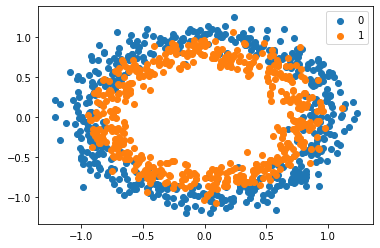

In [ ]:
# generación de círculos
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

plt.scatter(X[np.where((y==0)),0],X[np.where((y==0)),1], label='0')
plt.scatter(X[np.where((y==1)),0],X[np.where((y==1)),1], label='1')
plt.legend()
plt.show()

In [ ]:
# Creación del modelo
def build_model2(activation = 'sigmoid', loss='binary_crossentropy'):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(50,input_dim=2, activation='relu',kernel_initializer='he_uniform'))
  model.add(keras.layers.Dense(1, activation = activation))
  opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
  model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
  return model

Train: 0.834, Test: 0.848


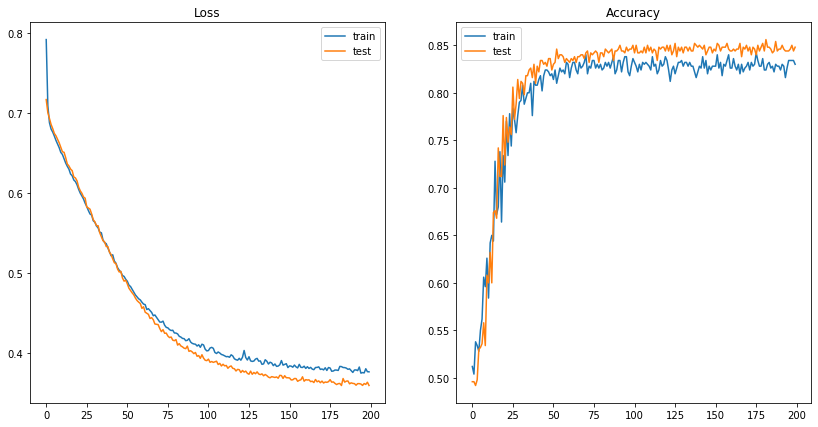

In [ ]:
# binary cross entropy:

keras.backend.clear_session()

# Prerprocesado de los datos

n_train = 500
train_X, test_X = X[:n_train, :], X[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

model = build_model2()

history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=200, verbose=0)

# Evaluación del modelo
_, train_acc = model.evaluate(train_X, train_y, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Gráficas:
plt.figure(figsize=(14,7))

# Gráfica de pérdidas durante el entrenamiento
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# Gráfica de las precisión durante el entrenamiento
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [ ]:
# Hinge Loss:

keras.backend.clear_session()

# Prerprocesado de los datos

# change y from {0,1} to {-1,1}
y_HL = np.zeros_like(y)
y_HL[np.where(y == 0)]=-1
y_HL[np.where(y == 1)]=1

# change y from {0,1} to {-1,1}
#y[np.where(y == 0)] = -1

n_train = 500
train_y, test_y = y_HL[:n_train], y_HL[n_train:]

model = build_model2(activation='tanh', loss='hinge')

history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=200, verbose=0)

# Evaluación del modelo
_, train_acc = model.evaluate(train_X, train_y, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Gráficas:
plt.figure(figsize=(14,7))

# Gráfica de pérdidas durante el entrenamiento
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# Gráfica de las precisión durante el entrenamiento
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Train: 0.310, Test: 0.332


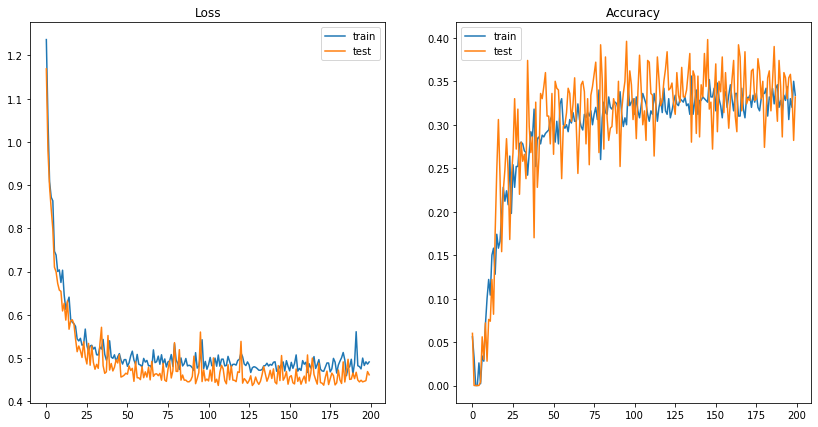

In [ ]:
# Squared Hinge Loss:
model = build_model2(activation='tanh', loss='squared_hinge')

history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=200, verbose=0)

# Evaluación del modelo
_, train_acc = model.evaluate(train_X, train_y, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Gráficas:
plt.figure(figsize=(14,7))

# Gráfica de pérdidas durante el entrenamiento
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# Gráfica de las precisión durante el entrenamiento
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## **Funciones de pérdida en el problema de clasificación multi-clase**

En el caso de clasificación multiclase, la función de perdida total se calcula como la suma sobre de la función de perdida para cada clase, por instancia, es decir:

$$-\sum_{c=1}^M y_{o,c}\text{log}(p_{o,c})$$

en donde $M$ es el número de clases, $y_{o,c}$ denota un indicador binario si la clase c corresponde a la clasificación correcta para la observación o, y $p_{o,c}$ inidica la probabilidad de que la observación o sea de la clase c.

En el caso de clasificaciones multiclase tendrelos las siguientes funciones de perdidas más comunes:

* **Función de entropía cruzada multiclase:**

Si la variable target estan codificadas de la forma **one-hot encoded**, se debe usar la función de entropia multiclase `categorical_crossentropy`. Si se tienen muchas clases es un dolor de cabeza usar el metodo de codificación **one-hot encoded**; en estos casos, es mejor usar una codificación entera, para lo cual se define otra función de perdida, la cual se define a renglón seguido.

* **Sparse Multiclass Cross-Entropy Loss**

En caso de que las variable target corresponde a enteros, se debe usar la entropía cruzada dispersa `sparse_categorical_crossentropy`.

* **Divergencia de Kullback Lieber (KL)**:

Es una medida de cómo una distribución de probabilidad difiere de una distribución de referencia. 

Si el valor es 0, ésto sugiere que las distribuciones son idénticas. En términos prácticos, la divergencia KL es muy similar a la entropía cruzada; en relación a que calcula la perdida de información (en términos de bits) si la distribución de probabilidad predicha se usa para aproximar la distribución de probabilidad target deseada. 

La divergencia KL se usa en los casos en los que el modelo a desarrollar es complejo, como en el caso que veremos en clases futuras del autoencoder usado para el aprendizaje de una representación densa de características, bajo un modelo que pretende reconstruir las entradas originales. No obstante, esta función de perdida puede ser usada en clasificación multiclase "simple", en cuyo caso es equivalente a la función de perdida multiclase de entropía cruzada. 


Usaremos la función de `scikit-learn` `make-blobs`, mediante la cual generaremos tres clases de círculos concéntricos de 1000 instancias con dos variables de entrada:

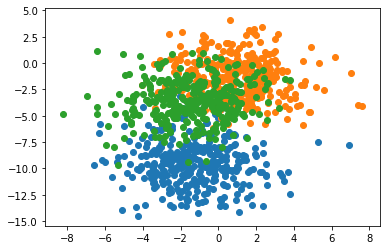

In [ ]:
# Generación de un dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# select indices of points with each class label

plt.scatter(X[np.where(y == 0), 0], X[np.where(y == 0), 1])
plt.scatter(X[np.where(y == 1), 0], X[np.where(y == 1), 1])
plt.scatter(X[np.where(y == 2), 0], X[np.where(y == 2), 1])
plt.show()

In [ ]:
# División de los datos:

y_c = keras.utils.to_categorical(y)

n_train = 500
train_X, test_X = X[:n_train, :], X[n_train:, :]
train_y, test_y = y_c[:n_train], y_c[n_train:]

In [ ]:
# Definición del modelo

def build_model3(loss='categorical_crossentropy'):
  # definición del modelo
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
  model.add(keras.layers.Dense(3, activation='softmax'))
  # compile model
  opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
  model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
  return model

Train: 0.820, Test: 0.834


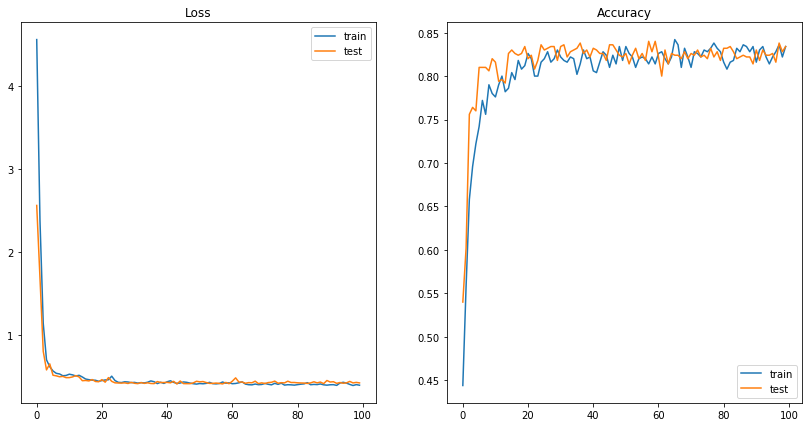

In [ ]:
# Categorical cross entropy
model = build_model3()

# Ajuste del modelo
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, verbose=0)

# Evaluación del modelo
_, train_acc = model.evaluate(train_X, train_y, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Gráficas:
plt.figure(figsize=(14,7))

# Gráfica de la perdida durante el entrenamiento.
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# Gráfica de la presición durante el entrenamiento.
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# División de los datos:

n_train = 500
train_X, test_X = X[:n_train, :], X[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

Train: 0.800, Test: 0.788


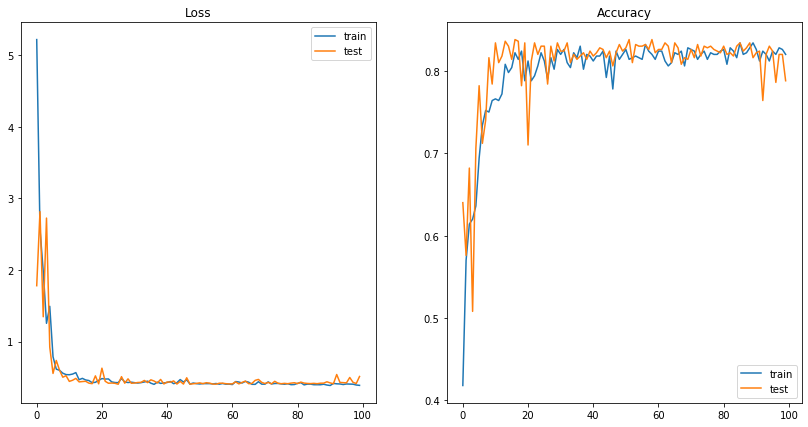

In [ ]:
# Sparse Multiclass Cross-Entropy Loss
model = build_model3(loss='sparse_categorical_crossentropy')

# Ajuste del modelo
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, verbose=0)

# Evaluación del modelo
_, train_acc = model.evaluate(train_X, train_y, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Gráficas:
plt.figure(figsize=(14,7))

# Gráfica de la perdida durante el entrenamiento.
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# Gráfica de la presición durante el entrenamiento.
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# División de los datos:

y_c = keras.utils.to_categorical(y)

n_train = 500
train_X, test_X = X[:n_train, :], X[n_train:, :]
train_y, test_y = y_c[:n_train], y_c[n_train:]

Train: 0.824, Test: 0.820


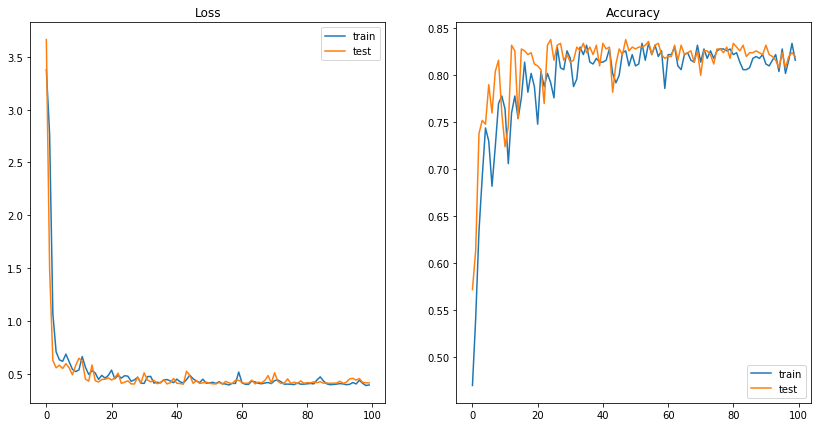

In [ ]:
# 'kullback_leibler_divergence'
model = build_model3(loss='kullback_leibler_divergence')

# Ajuste del modelo
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=100, verbose=0)

# Evaluación del modelo
_, train_acc = model.evaluate(train_X, train_y, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Gráficas:
plt.figure(figsize=(14,7))

# Gráfica de la perdida durante el entrenamiento.
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# Gráfica de la presición durante el entrenamiento.
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# Redes neuronales convolucionales (CNN)

Las redes neuronales convolucionales (CNN) surgieron del estudio de la corteza visual del cerebro, y se han utilizado en el reconocimiento de imágenes desde la década de 1980. En los últimos años, gracias al aumento en el poder computacional, la cantidad de datos de entrenamiento disponibles y los trucos presentados en la clase anteriro para entrenar redes profundas, las CNN han logrado alcanzar un rendimiento sobrehumano en algunas tareas visuales complejas. Impulsan servicios de búsqueda de imágenes, autos que se manejan solos, sistemas automáticos de clasificación de video y más. Además, las CNN no se limitan a la percepción visual: también tienen éxito en muchas otras tareas, como el reconocimiento de voz o el procesamiento del lenguaje natural (PNL).

La diferencia fundamental entre una capa densamente conectada y una capa de convolución (convolutional layer ) es que las capas densas aprenden patrones globales en su espacio de características de entrada (por ejemplo, para un dígito MNIST, patrones que involucran todos los píxeles), mientras que las capas de convolución aprenden patrones locales, enn el caso de imágenes, patrones encontrados en pequeñas ventanas de las caracteristicas de entrada. 

<p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/qdvojdR.png" align="center" hspace="10px" vspace="0px"></p> 

Esta característica clave otorga a las capas convolucionales dos propiedades interesantes:
* Los patrones que aprenden son invariantes de translacion. Después de aprender un cierto patrón en la esquina inferior derecha de una imagen, una CNN puede reconocerlo en cualquier lugar, por ejemplo, en la esquina superior izquierda. Una red densamente conectada tendría que aprender el patrón nuevamente si apareciera en una nueva ubicación. Esto hace que los datos de las CNN sean eficientes cuando se procesan imágenes (porque el mundo visual es fundamentalmente invariante ante translacion).

* Pueden aprender jerarquías espaciales de patrones: una primera capa de convolución aprenderá pequeños patrones locales como los bordes, una segunda capa de convolución aprenderá patrones más grandes hechos de las características de las primeras capas, y así sucesivamente. Esto permite que las CNN aprendan eficientemente conceptos visuales cada vez más complejos y abstractos (porque el mundo visual es fundamentalmente jerárquico espacialmente).

<p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/FaeuJas.png" align="center" hspace="10px" vspace="0px"></p> 

Ahora que tenemos una idea de que son las CNN pasemos a ver el elemento que hace tan especiales a las CNN, esto es , las capas convolucionales. 

## Convolutional layer
Una capa convolucional tiene por lo general tres etapas como se muestra en la figura 

<p><img alt="Colaboratory logo" height="450px" src="https://i.imgur.com/PyoAVmM.png" align="center" hspace="10px" vspace="0px"></p> 

Vemos cada una de estas etapas con un poco mas de detalle 

## Stage 1:  Convolución

La convolución (en el contexto las redes neuronales convolucionales) es básicamente una correlación cruzada (sin embargo la seguiremos llamando convolución), la cual, en procesamiento de señales, es una medida de la similitud entre dos señales, frecuentemente usada para encontrar características relevantes en una señal desconocida por medio de la comparación con otra que sí se conoce.
Matematicamente la correlacion cruzada (en el caso discreto) se defien como:

\begin{equation}
S[t] = (X * W)(t) = \sum_a X[a]W[t+a]
\end{equation}

para entender mejor el concepto de convolución veamos un ejemplo simple usando dos señales. 

### Ejemplo : dos señales 1-dimensional

Para ver de forma mas detalla como se hacen animacion con matplotlib en google colab puede visitar el link: https://colab.research.google.com/drive/1lnl5UPFWVPrryaZZgEzd0theI6S94c3X#scrollTo=OEwd0xc5eGz9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
#import seaborn as sns; sns.set()

In [ ]:
# Primero configure la figura, el eje y el elemento de la trama que queremos animar
fig, ax = plt.subplots(figsize=(13,8) )
plt.close()

y1 = np.array([0.1,0.2,-0.1,4.1,-2,1.5,-0.1])
x1=np.arange(1,len(y1)+1)
ax.plot(x1,y1+7,'o-')

ax.set_xlim(( -7, 15))
ax.set_ylim((-3, 12))
ax.set_yticks([])
ax.set_xticks([])
line, = ax.plot([], [], 'o-r')

In [ ]:
# función de inicialización: traza el fondo de cada cuadro
def init():
    line.set_data([], [])
    return (line,)

# función de animación
def animate(i):
  i=i-6
  y2 = np.array([0.1,4,-2.2,1.6,0.1,0.1,0.2])
  x=np.arange(1,len(y2)+1)+i
  line.set_data(x, y2)
  ax.set_title('cross correlation=%.3f' %(np.correlate(y1,y2,mode='full'))[6+i], fontsize=20)
  for t in ax.texts:
    t.set_visible(False)

  for i in range(len(x)):
    ax.text(x1[i], y1[i]+7, str(y1[i]))
    ax.text(x[i], y2[i], str(y2[i]))

    
  return (line,)

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=7+6, interval=2000, blit=True)

rc('animation', html='jshtml')
anim

como se puede observar , el valor más grande de correlación cruzada es $23.18$. Si comparamos la forma de las señales justo para este valor de correlación vemos que la forma de las señales es bastante parecida. Vemos entonces que la correlación cruzada es un indicador de la similitud de la forma ( de las características ) de estas dos señales.  

### Caso extendido 

En el contexto de las CNNs, estas señales son multidimensionales y no solo 1-dimensional como en el ejemplo que acabamos de ver. Consideremos por ejemplo el caso de una imagen 2-dimensional (supongamos una imagen a blanco y negro), para este caso nuestra ecuación para la convolución(correlación cruzada) la siguiente forma:


\begin{equation}
S[i,j] = (I * K)[i,j] = \sum_m \sum_n I[m,n]W[m+i,n+j]
\end{equation}

Donde en el contexto de las CNNs, la señal $K$ es conocida como Kernel. En la ecuación anterior estamos haciendo la convolución de la imagen $I$ con el Kernel $K$.

veamos un ejemplo práctico de esto para entender un poco mejor qué es lo que sucede

#### Ejemplo: imagen 2-dimensional 

Consideremos la siguiente imagen y el sigueinte kernel

In [ ]:
I = np.array([[1,1,1,0,0], [0,1,1,1,0], [0,0,1,1,1], [0,0,1,1,0], [0,1,1,0,0]])
K = np.array([[1,0,1],[0,1,0],[1,0,1]])

In [ ]:
print(I)

[[1 1 1 0 0]
 [0 1 1 1 0]
 [0 0 1 1 1]
 [0 0 1 1 0]
 [0 1 1 0 0]]


In [ ]:
print(K)

[[1 0 1]
 [0 1 0]
 [1 0 1]]


Ahora usemos la libreria de Scipy para realizar la convolucion 

In [ ]:
from scipy.signal import convolve2d

In [ ]:
convolve2d(I,K, mode='valid')

array([[4, 3, 4],
       [2, 4, 3],
       [2, 3, 4]])




![](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)

Este tipo de convolución es es conocida como convolucion valid.

Realizando esta operación de convolución entre $I$ y $K$, podemos capturar algunas de las características de la imagen que son similares a las de nuestro kernel. Para apreciar mejor esta idea , veamos un ejemplo con una imagen más grande.



#### Convolucion en imagen mas grande

Por ahora consideremos una imagen a blanco y negro , sin embargo más adelante veremos que las imágenes pueden venir con más canales (pro ejemplo los ampliamente conocidos RGB)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.signal import convolve2d

In [3]:
image= mpimg.imread('https://i.imgur.com/R2mS8Oh.png')

In [4]:
image.shape

(776, 578)

In [15]:
K=np.array([[1,1,1],
           [0,0,0],
           [-1,-1,-1]])

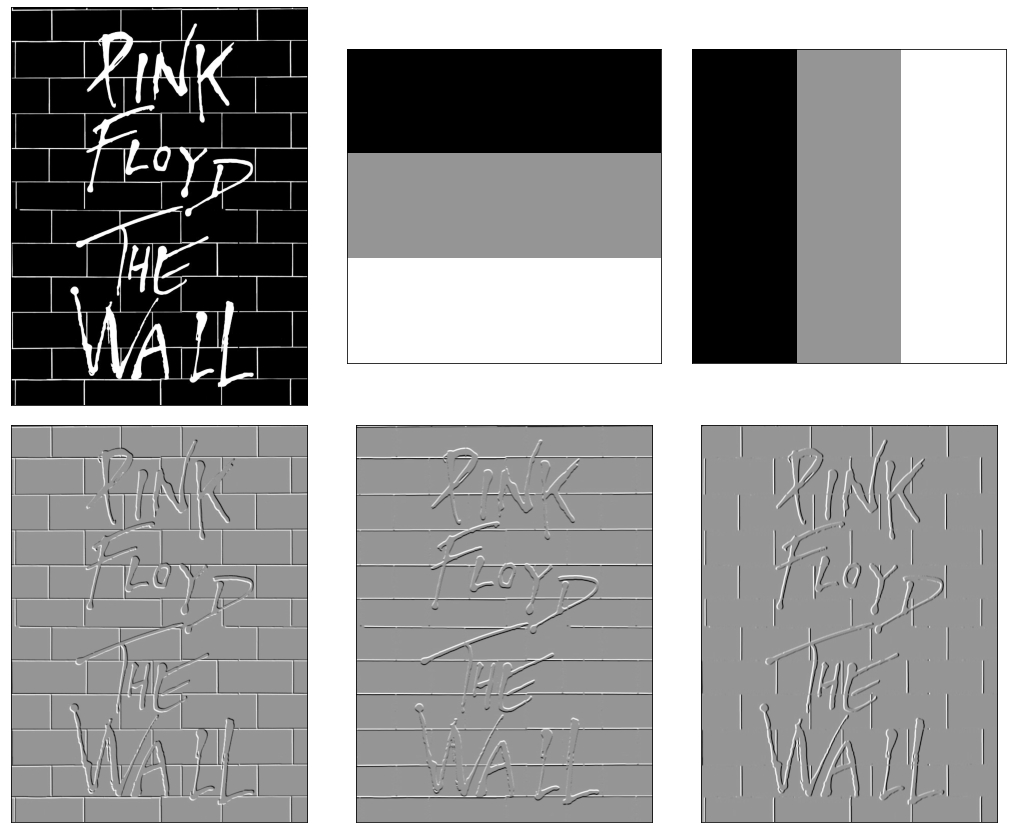

In [20]:
fig , ax = plt.subplots(2,3, figsize=(18,15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.05, wspace=0.1))
ax[0,0].imshow(image, cmap='Greys' )

ax[0,1].imshow(K,cmap='Greys')
ax[0,2].imshow(K.T,cmap='Greys')
ax[1,1].imshow(convolve2d(image,K, mode='valid'), cmap='Greys')
ax[1,2].imshow(convolve2d(image,K.T, mode='valid'), cmap='Greys')
ax[1,0].imshow(convolve2d(image,K.T, mode='valid')-convolve2d(image,K, mode='valid'), cmap='Greys')

En las CNNs los kernels son aprendidos por nuestro algoritmo, es decir,  basados en las predicciones que queremos realizar , le decimos a nuestro modelo que encuentre cuál es el mejor kernel para dicha tare.  

### Efectos de borde, y strides
como se vio en el ejemplo anterior, después de realizar la operación de convolución la imagen redujo su tamaño. En general, el ancho y alto de la imagen de salida pueden diferir del ancho y alto de la imagen de entrada debido a dos razones: 

*  Efectos de borde, que se pueden contrarrestar usando el metodo llamado padding.

*  El uso de strides


#### Efectos de borde y padding 

Consideremos el ejemplo de nuestra imagen de 5x5 píxeles, y un kernel de 3x3.
<p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/uyepS9e.png" align="center" hspace="10px" vspace="0px"></p> 


si queremos que el tamaño de nuestra imagen de salida (esto es, después de aplicar la operación de convolución con el kernel) tenga el mismo tamaño de nuestra imagen de entrada podemos usar la técnica llamada padding. Padding consiste en agregar un número apropiado de filas y columnas a cada lado de la imagen para que así la imagen de salida tenga las mismas dimensiones de la imagen de entrada. Para un kernel 3×3, agrega una columna a la derecha, una columna a la izquierda, una fila en la parte superior y una fila en la parte inferior.

<p><img alt="Colaboratory logo" height="250px" src="https://i.imgur.com/p1MdvHF.png" align="center" hspace="10px" vspace="0px"></p> 

La convolución que consta de padding y luego convolución , es conocida como convolución “Same”. Veamos un ejemplo de esto usando scipy 


In [ ]:
convolve2d(I,K, mode='same')

array([[ 1,  2,  3,  2,  1],
       [-2, -2,  0,  2,  2],
       [-1, -1, -1,  0,  0],
       [ 1,  1,  0, -2, -2],
       [ 0, -1, -2, -2, -1]])

Usualmente el padding se realiza agregando columnas y filas de ceros

<p><img alt="Colaboratory logo" height="350px" src="https://i.imgur.com/5BoEHiY.png" align="center" hspace="10px" vspace="0px"></p> 



#### Strides 

Como vimos en el ejemplo de la imagen 5x5 , cuando desplazamos nuestro kernel en la imagen para realizar la operación de convolución , nos desplazamos solo una columna o solo una fila, sin embargo estos desplazamientos son un parámetro de la convolución llamado stride y en general puede ser diferente de uno. 
<p><img alt="Colaboratory logo" height="350px" src="
https://i.imgur.com/vMGjDk9.png" align="center" hspace="10px" vspace="0px"></p>

Debido a fijar los stides diferente de uno , la imagen puede verse reducida después de la operación de convolución.


## Stage 2: Detector Stage (activation stage)

Esta etapa es similar a la que ya conocemos de las DNN, se trata de aplicar una transformación no lineal (funciones de activación) tales como Relu, Tanh, etc.



## Stage 3: Pooling

En la etapa de Polling vamos a calcular un resumen estadístico de nuestra imagen una vez a pasado por las dos etapas anteriores ( esto es , convolution  y detector stage). Hay varias razones para realizar esto: 

* Reducir la imagen de entrada para reducir la carga computacional, el uso de memoria y el número de parámetros (lo que limita el riesgo de overfitting).

* Introducir cierto nivel de invariancia a pequeñas traslaciones.

Hay diferentes formas de hacer pooling , entre las más conocidas están Max Polling ( The maximum of a rectangular neighborhood) 

<p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/BW48gCv.png" align="center" hspace="10px" vspace="0px"></p>

Ahora tenemos todas las herramientas para construir nuestras CNN


## Forma mas gerenal 
Hasta ahora, por simplicidad, hemos representado la salida de cada capa convolucional como una delgada capa 2D, pero en realidad una capa convolucional tiene múltiples Kernels (filtros), y genera un mapa de características por filtro, por lo que es representado con mayor precisión en 3D.

Además, las imágenes de entrada también se componen de múltiples subcapas: una por canal de color. Normalmente hay tres: rojo, verde y azul (RGB). Las imágenes en escala de grises tienen solo un canal, pero algunas imágenes pueden tener mucho más, por ejemplo, imágenes satelitales que capturan frecuencias de luz adicionales (como infrarrojo).
<p><img alt="Colaboratory logo" height="400px" src="https://i.imgur.com/OuDTED7.png" align="center" hspace="10px" vspace="0px"></p>


## La arquitectura tipica de las CNN es como se muestra en la figura de abajo 

<p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/BqlLRkJ.png" align="center" hspace="10px" vspace="0px"></p>






http://arxiv.org/abs/1311.2901

In [ ]:
from tensorflow import keras

In [ ]:
keras.backend.clear_session()

### **Implementación de una red convolusional en Keras**
La construcción de nuestra red se da de manera similar a como se ha venido realizando, solo que para este caso debemos añadir capas convolucionales, es decir que realicen el proceso de convolución. Keras cuenta con diferentes tipos de capas convolucionales, esta será definida de acuerdo a nuestras necesidades, estás se pueden ver en el siguiente [link](https://keras.io/layers/convolutional/). 

Veamos como sería la implementación para el caso de una **convolución2D**. Al crear nuestra red se añade la capa de la siguiente manera:



In [ ]:
mod=keras.models.Sequential([
      keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='valid',activation='relu',use_bias=True,kernel_initializer='he_uniform', bias_initializer='zeros')
])

En la línea de código anterior de forma didáctica se construyó una capa convolucional en la forma que se hace en keras, allí solo tuvimos en cuenta algunos argumentos. Esta capa crea un kernel de convolución que se convoluciona  (valga la redundancia) con capa de entrada para producir un tensor como salida. Dado el caso de que esta sea nuestra capa de entrada, recordemos debemos entrar la forma de neustros datos, donde este será la forma de neustra matriz más la componente que nos dará el número de canales que se tenga. 

Los argumentos en la anterior capa hacen referencia a :
* **Filters:** Entrada para el número de filtro que usará nuestra capa, valor entero.
* **kernel_size:** Recibe una tupla como entrada en la que le daremos el valor de la altura y el ancho de nuestro filtro (kernel), si le damos un entero como en este caso, keras interpretará como que tiene ese mismo valor en la altura y el ancho.
* **Strides:** Recibe una tupla como entrada en la que específicamos los strides, en dirección horizontal y vertical.

* **Padding:** recibe como argumento 'valid' o 'same', donde en la primera no tendremos padding y con la segunda nuestra salida tendrá las mismas dimensiones que nuestra entrada.
* **Activation:** Función de activación, juega el papel que ya hemos visto en las anteriores clase.
* **use_bias:** Me permite definir si mi capa tendrá un vector de preferencia o sesgo (bias vector).

* **initializers:** Forma de inicializar mis parámetros, ya sea del kernel o del vector de preferencias.

Para este tipo de capa tenemos unos cuantos argumentos más que se pueden consultar en el siguiente [link](https://keras.io/layers/convolutional/)

Veamos como se da la implementación de una capa convolucional en una red, para esto haremos un ejemplo en el cual usando el **fashion mnist** dataset compararemos las diferencias entre la implementación con una red densa multicapa y una red convoluvional. Para eso lo primero que haremos es impotar las librerías necesarias y cargar el dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full.shape

(60000, 28, 28)

Como vimos en clases pasadas, un punto importante es la normalización de los datos, en este caso nuestros pixeles, esto es lo que realizaremos en el siguiente paso

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

En este dataset, recordemos que las etiquetas estan dadas por enteros del 0-9, así que para darle un nombre como tal a cada una debemos tener el siguiente arreglo con las clases.

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
class_names[y_train[0]]

'Coat'

In [ ]:
print('X_valid:',X_valid.shape,'\t','X_test:',X_test.shape,'\t','X_train:',X_train.shape)

X_valid: (5000, 28, 28) 	 X_test: (10000, 28, 28) 	 X_train: (55000, 28, 28)


Veamos algunos de los elementos que podemos encontrar en nuestro dataset

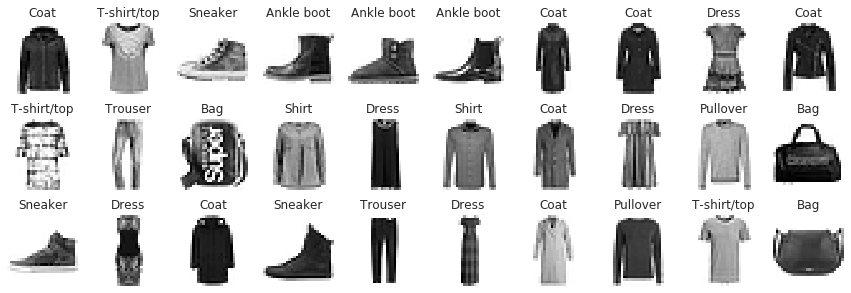

In [ ]:
fig , ax =  plt.subplots(3,10, figsize=(15,5))
for i , ax in enumerate(ax.flat):
  ax.imshow(X_train[i], cmap='binary')
  ax.set_axis_off()
  ax.set_title(class_names[y_train[i]])

Veamos como sería la implementación de una red densa profunda, la cual ya hemos visto en clases pasadas.

In [ ]:
keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential();
model.add(keras.layers.Flatten(input_shape=[28, 28]));
model.add(keras.layers.Dense(300, activation="relu"));
model.add(keras.layers.Dense(100, activation="relu"));
model.add(keras.layers.Dense(10, activation="softmax"));

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

In [ ]:
history =  model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 111us/sample - loss: 0.7075 - acc: 0.7666 - val_loss: 0.5433 - val_acc: 0.8062
Epoch 2/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.4830 - acc: 0.8327 - val_loss: 0.4390 - val_acc: 0.8460
Epoch 3/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.4405 - acc: 0.8458 - val_loss: 0.4150 - val_acc: 0.8600
Epoch 4/20
55000/55000 [==============================] - 5s 95us/sample - loss: 0.4126 - acc: 0.8563 - val_loss: 0.4064 - val_acc: 0.8602
Epoch 5/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3918 - acc: 0.8626 - val_loss: 0.3852 - val_acc: 0.8656
Epoch 6/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3786 - acc: 0.8668 - val_loss: 0.3665 - val_acc: 0.8702
Epoch 7/20
55000/55000 [==============================] - 5s 95us/sample - loss: 0.3644 - acc: 0.8708 - val_loss: 0.

Veamos el comportamiento en la curva de validación.

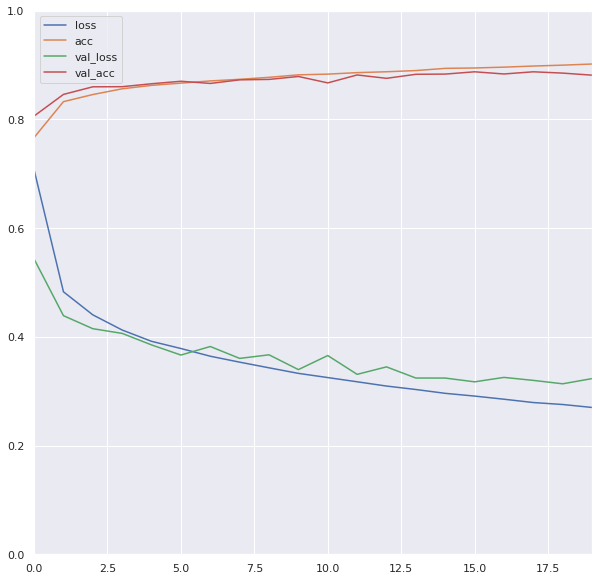

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 72.6691 - acc: 0.8300


[72.66911121129989, 0.83]

Ahora veamos una implementación de una red neuronal en la cual tenemos dos capas convolucionales en las cuales la Detector stage usaremos como activación la **relu**.

In [ ]:
keras.backend.clear_session()

In [ ]:
model2= keras.models.Sequential();
model2.add(keras.layers.Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)));
model2.add(keras.layers.Conv2D(32, kernel_size=3, activation="relu"));
model2.add(keras.layers.Flatten());
model2.add(keras.layers.Dense(100, activation="relu"));
model2.add(keras.layers.Dense(10, activation="softmax"));

**Opcional:** Podemos usar el Early stopping, para que nuestro modelo se detenga cuando empiece a aumentar el valor de la función de perdida en el conjunto de validación.

In [ ]:
from keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='val_loss',patience=1)

Usamos el mismo compilador anterior.

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

En este caso como usaremos imagenes en escala de grises, debemos hacer un reshape a nuestros datos, de forma tal que los entreguemos en la forma que nuestra red los espera, donde la primer componente hace referencia al número de imagenes, las dos siguientes a las formas de estas (28$\times$28), y finalamente la última hace referencia a los canales.

In [ ]:
X_train1=X_train.reshape(55000,28,28,1)
X_valid1=X_valid.reshape(5000,28,28,1)

In [ ]:
history2=  model2.fit(X_train1, y_train, epochs=20, validation_data=(X_valid1, y_valid),callbacks=[es])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 13s 237us/sample - loss: 0.3800 - acc: 0.8625 - val_loss: 0.2660 - val_acc: 0.9038
Epoch 2/20
55000/55000 [==============================] - 13s 238us/sample - loss: 0.2357 - acc: 0.9126 - val_loss: 0.2491 - val_acc: 0.9082
Epoch 3/20
55000/55000 [==============================] - 14s 249us/sample - loss: 0.1769 - acc: 0.9354 - val_loss: 0.2209 - val_acc: 0.9226
Epoch 4/20
55000/55000 [==============================] - 14s 246us/sample - loss: 0.1263 - acc: 0.9529 - val_loss: 0.2383 - val_acc: 0.9216


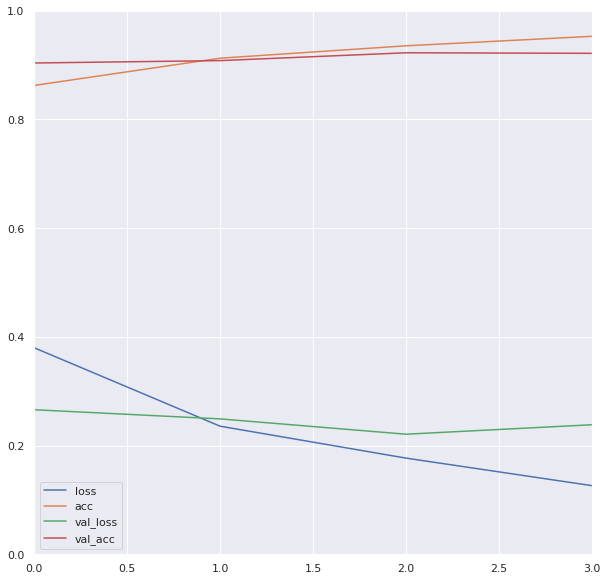

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Podemos ver como una red con una capa convolucional mejora bastante mi modelo, en un número de épocas menor.

### **Pooling en keras**
Keras además nos permite tener capas de pooling en nuestras redes convolucionales, las cuales se pueden definir de la siguiente manera:

In [ ]:
mod=keras.models.Sequential([
      keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='valid',activation='relu',use_bias=True,kernel_initializer='he_uniform', bias_initializer='zeros'),
      keras.layers.MaxPooling2D(pool_size=(2,2),strides=None,padding='valid')
])

Donde vemos tenemos la capa que explicamos al inicio de esta sección (convolucional) y le añadimos una capa de pooling, donde los argumentos son el tamaño del pool, el stride y el padding. Para más información sobre capas Pooling ir al siguiente [link](https://keras.io/layers/pooling/). Veamos que pasará en el mnist dataset en una red en la cual añadimos una capa de pooling

In [ ]:
keras.backend.clear_session()
model3= keras.models.Sequential();
model3.add(keras.layers.Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)));
model3.add(keras.layers.Conv2D(32, kernel_size=3, activation="relu"));
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)));
model3.add(keras.layers.Flatten());
model3.add(keras.layers.Dense(100, activation="relu"));
model3.add(keras.layers.Dense(10, activation="softmax"));

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

In [ ]:
history3=  model3.fit(X_train1, y_train, epochs=20, validation_data=(X_valid1, y_valid),callbacks=[es])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 15s 276us/sample - loss: 0.3870 - acc: 0.8609 - val_loss: 0.2607 - val_acc: 0.9084
Epoch 2/20
55000/55000 [==============================] - 15s 267us/sample - loss: 0.2463 - acc: 0.9089 - val_loss: 0.2592 - val_acc: 0.9076
Epoch 3/20
55000/55000 [==============================] - 15s 264us/sample - loss: 0.1959 - acc: 0.9273 - val_loss: 0.2486 - val_acc: 0.9120
Epoch 4/20
55000/55000 [==============================] - 12s 226us/sample - loss: 0.1533 - acc: 0.9428 - val_loss: 0.2210 - val_acc: 0.9254
Epoch 5/20
55000/55000 [==============================] - 12s 214us/sample - loss: 0.1226 - acc: 0.9544 - val_loss: 0.2301 - val_acc: 0.9272


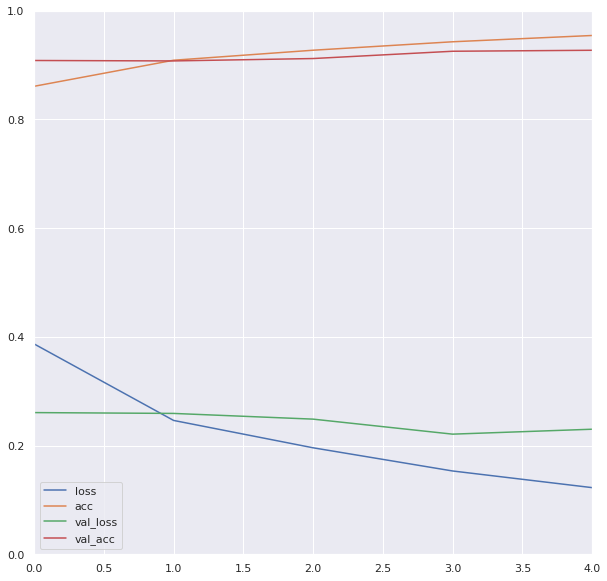

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Donde podemos ver que la diferencia al añadirle esta capa no es mucha para este caso. Sin embargo estas capas son de gran ayuda en ciertos casos.